In [2]:
import tensorflow_datasets as tfds

imdb, info= tfds.load("imdb_reviews", with_info = True, as_supervised =True)
train_data, test_data = imdb["train"], imdb["test"]

for text, label in train_data.take(1):
    print("review:", text.numpy()[:500])
    print("label:", label.numpy())

review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but"
label: 0


2025-09-22 15:14:58.140074: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-09-22 15:14:58.170132: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-09-22 15:14:58.172373: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
import pandas as pd

train_examples=[(text.numpy().decode("utf-8"), int(label.numpy())) for text, label in train_data]
test_examples=[(text.numpy().decode("utf-8"), int(label.numpy())) for text, label in test_data]

df_train = pd.DataFrame(train_examples, columns=["review", "sentiment"])
df_test = pd.DataFrame(test_examples, columns=["review", "sentiment"])

print(df_train.shape, df_test.shape)
df_train.head()

(25000, 2) (25000, 2)


,review,sentiment
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Vectorizer = TfidfVectorizer(lowercase=True, stop_words = "english", max_features=10000)
X_train = Vectorizer.fit_transform(df_train["review"])
X_test = Vectorizer.transform(df_test["review"])

y_train = df_train["sentiment"]
y_test = df_test["sentiment"]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (25000, 10000)
Test shape: (25000, 10000)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))




Logistic Regression Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [20]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.86008
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

Tokenizer = Tokenizer(num_words=10000, oov_token="<oov>")
Tokenizer.fit_on_texts(df_train["review"])

X_train_seq=Tokenizer.texts_to_sequences(df_train["review"])
X_test_seq=Tokenizer.texts_to_sequences(df_test["review"])

max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post")

X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post")

y_train = df_train["sentiment"].values
y_test = df_test["sentiment"].values

model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(16, activation= "relu"),
    Dense(1, activation = "sigmoid"),
    ])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_pad, y_train, epochs=5, batch_size=512, validation_data=(X_test_pad, y_test))



Epoch 1/5


2025-09-29 12:15:35.131796: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 20000000 exceeds 10% of free system memory.


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5370 - loss: 0.6915

2025-09-29 12:15:48.326647: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 20000000 exceeds 10% of free system memory.


49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - accuracy: 0.5783 - loss: 0.6889 - val_accuracy: 0.6127 - val_loss: 0.6811
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.7172 - loss: 0.6620 - val_accuracy: 0.7331 - val_loss: 0.6361
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.7688 - loss: 0.5939 - val_accuracy: 0.7927 - val_loss: 0.5523
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8190 - loss: 0.4979 - val_accuracy: 0.8164 - val_loss: 0.4681
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.8473 - loss: 0.4158 - val_accuracy: 0.8404 - val_loss: 0.4021


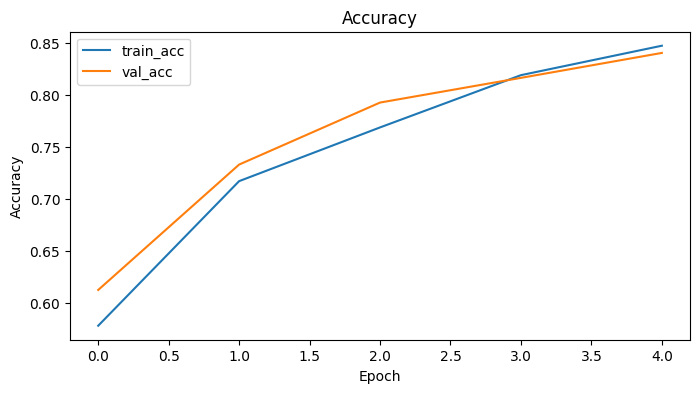

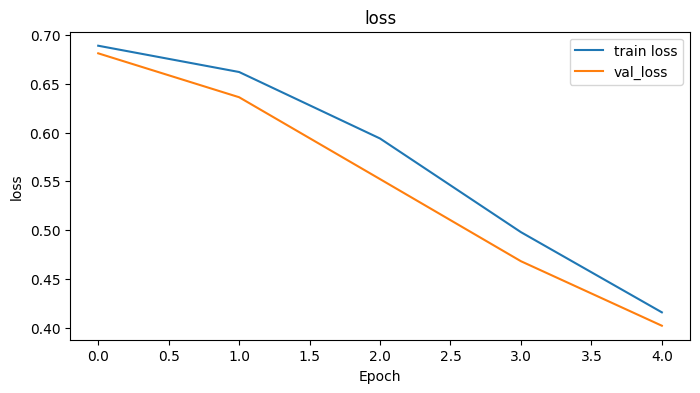

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


2025-09-29 12:50:42.354183: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 20000000 exceeds 10% of free system memory.


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
classification report: 
              precision    recall  f1-score   support

           0     0.8497    0.8270    0.8382     12500
           1     0.8315    0.8538    0.8425     12500

    accuracy                         0.8404     25000
   macro avg     0.8406    0.8404    0.8403     25000
weighted avg     0.8406    0.8404    0.8403     25000



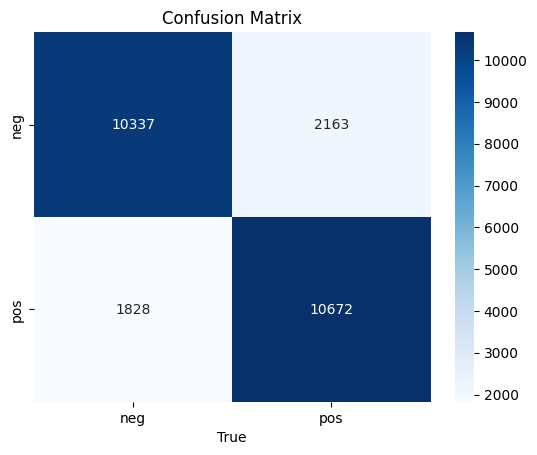

ROC AUC: 0.9195


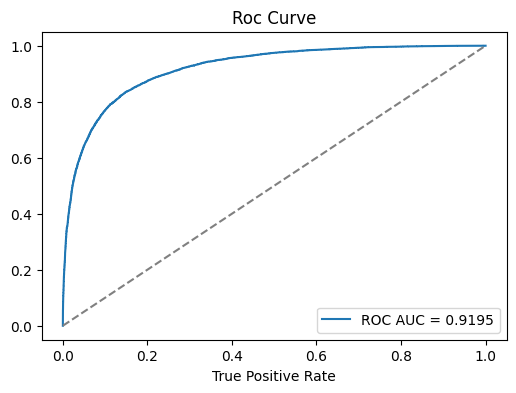

NameError: name 'h' is not defined

In [53]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

y_proba = model.predict(X_test_pad, batch_size=512)
y_proba = y_proba.ravel()
y_pred = (y_proba >=0.5).astype(int)

print("classification report: ")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
plt.xlabel('Predict')
plt.xlabel('True')
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", round(roc_auc, 4))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize = (6,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], '--', color='grey')
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Roc Curve')
plt.legend()
plt.show()



In [58]:
import os, joblib, json

os.makedirs("../models", exist_ok=True)
os.makedirs("../models/sklearn", exist_ok = True)

#save NN
model.save("../models/imdb_nn.h5")

#save tokenizer
tokenizer_json = Tokenizer.to_json() 
with open("../models/tokenizer.json", "w") as f:
    f.write(tokenizer_json)

#save baseline models
joblib.dump(log_reg, "../models/sklearn/log_reg.joblib")
joblib.dump(svm, "../models/sklearn/log_svm.joblib")

['../models/sklearn/log_svm.joblib']

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

#load NN
nn = load_model("../models/imdb_nn.h5")
print("loaded NN ok")

#load tokenizer
with open("../models/tokenizer.json") as f:
    tok = tokenizer_from_json(f.read())
print("Loaded tokenizer ok")

#load sklearn models
import joblib
log = joblib.load("../models/sklearn/log_reg.joblib")
svm = joblib.load("../models/sklearn/log_svm.joblib")
print("loaded sklearn models ok")



loaded NN ok
Loaded tokenizer ok
loaded sklearn models ok


In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def predict_sentiment_texts(texts, model = nn, Tokenizer = tok, max_length = 20):
    seq = tok.texts_to_sequences(texts)
    pad = pad_sequences(seq, maxlen = max_length, padding ="post")
    probs = model.predict(pad).ravel()
    labels = (probs >= 0.5).astype(int)
    return probs.tolist(), labels.tolist()
#quick test
examples = ["i loved the film", "It was boring and too slow"]
probs, labels = predict_sentiment_texts(examples)
for t,p,l in zip(examples, probs, labels):
    print(f"{l} ({p: .3f}) : {t}")

    


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1 ( 0.932) : i loved the film
0 ( 0.168) : It was boring and too slow


In [20]:
.ipynb_checkpoints/


SyntaxError: invalid syntax (2031101423.py, line 1)